In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


**Importing the libraries**

In [51]:
from fastai import *
from fastai.tabular import *

In [70]:
from scipy import stats
from scipy.signal import hann
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

In [ ]:
path = Path("../input")

In [ ]:
print('There are {} files in test folder '.format(len(os.listdir(os.path.join("../input", 'test' )))))

In [ ]:
%%time
df_train = pd.read_csv(path/'train.csv',dtype={'acoustic_data':np.int16,'time_to_failure':np.float32})

In [ ]:
df_train.shape

In [ ]:
df_train.head(2)

**Data Exploration**

In [ ]:
train_acoustic_df = df_train['acoustic_data'][:10]

In [ ]:
train_acoustic_df =df_train['acoustic_data'].values[::100]
train_acoustic_df.shape

In [ ]:
train_time_to_failure_df = df_train['time_to_failure'].values[::100]

In [ ]:
%matplotlib inline
import matplotlib

In [ ]:
def plot_acc_ttf_data(train_acoustic_df,train_time_to_failure_df,title='Acoustic data and time to failure: sampled 1%'):
    fig ,ax1 = plt.subplots(figsize=(12,9))
    plt.title(title)
    plt.plot(train_acoustic_df,color='r')
    ax1.set_ylabel('train_acoustic_df',color='r')
    plt.legend(['acoustic-data'],loc=(0.01,0.95))
    ax2 = ax1.twinx()
    plt.plot(train_time_to_failure_df,color='b')
    ax2.set_ylabel('time to failure',color='b')
    plt.legend(['time_to_failure'],loc=(0.01,0.9))
    plt.grid(True)
    
    

In [ ]:
plot_acc_ttf_data(train_acoustic_df,train_time_to_failure_df)

In [ ]:
del train_time_to_failure_df
del train_acoustic_df

In [ ]:
train_acoustic_df = df_train['acoustic_data'].values[:6291455]
train_time_to_failure_df = df_train['time_to_failure'].values[:6291455]

In [ ]:
plot_acc_ttf_data(train_acoustic_df,train_time_to_failure_df)

In [52]:
rows=150000

df_train.shape

segments = int(np.floor(df_train.shape[0]/rows))
print("number of segments ",segments)

number of segments  4194


In [53]:
train_X = pd.DataFrame(index=range(segments),dtype=np.float64)
train_y= pd.DataFrame(index=range(segments),dtype=np.float64,columns=['time_to_failure'])

In [59]:
total_mean= df_train['acoustic_data'].mean()
total_std= df_train['acoustic_data'].std()
total_max= df_train['acoustic_data'].max()
total_min= df_train['acoustic_data'].min()
total_sum= df_train['acoustic_data'].sum()
total_abs_sum= np.abs(df_train['acoustic_data']).sum()

In [63]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

In [64]:
def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [68]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [71]:
for seg_id in tqdm(range(segments)):
    seg = df_train.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]


100%|██████████| 4194/4194 [19:45<00:00,  3.58it/s]


In [72]:
df = pd.concat([train_X, train_y], axis=1)

In [73]:
dep_var = 'time_to_failure'
cont_names = None
cat_names = None

procs = [FillMissing, Categorify, Normalize]


In [75]:
submission = pd.read_csv(path/'sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [76]:
for seg_id in tqdm(test_X.index):
    seg = pd.read_csv(path/f'test/{seg_id}.csv')
    create_features(seg_id, seg, test_X)

100%|██████████| 2624/2624 [13:27<00:00,  3.32it/s]


In [77]:
test_X.reset_index(inplace=True)

In [78]:
df = pd.concat([train_X, train_y], axis=1)

In [79]:
df.to_feather("df")
test_X.to_hdf('df_test.h5', key="df_test")
df = pd.read_feather("df")
test_df = pd.read_hdf('df_test.h5', key="df_test")

In [80]:
dep_var = 'time_to_failure'
cont_names = None
cat_names = None

procs = [FillMissing, Categorify, Normalize]

In [81]:
data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=range(0,800), procs=procs, test_df=test_df)

In [82]:
data.show_batch(rows=10)

min_roll_mean_100,q99_roll_std_1000,mean_change_rate_first_10000,mean_change_rate,Moving_average_6000_mean,min_roll_std_100,Rmax_last_5000,ave_roll_std_10,abs_mean,av_change_abs_roll_std_100,q95_roll_mean_100,abs_max_roll_mean_10,min_roll_std_1000,kurt,mean_change_abs,min,q05,av_change_abs_roll_std_10,q001,min_first_10000,Imean,Rstd__last_5000,skew,ave_roll_std_100,std_first_10000,std_last_50000,mean_change_rate_last_10000,iqr,MA_700MA_BB_low_mean,std_last_10000,max_last_50000,avg_first_50000,Rmean,min_roll_mean_10,avg_last_10000,max_roll_mean_10,q95_roll_mean_10,avg_first_10000,abs_trend,max_first_10000,abs_max_roll_std_10,q01,q05_roll_std_1000,av_change_rate_roll_mean_1000,min_last_10000,q99_roll_mean_1000,ave10,q05_roll_std_10,abs_max,std_roll_std_10,Rmax_last_15000,q99_roll_std_10,av_change_rate_roll_std_100,exp_Moving_average_3000_mean,q01_roll_mean_10,max_roll_std_1000,q95_roll_std_100,q05_roll_mean_1000,std_roll_std_1000,q01_roll_mean_1000,max,trend,q95,q95_roll_std_10,abs_q95,Rmax,max_to_min_diff,q99,max_roll_mean_100,q01_roll_std_1000,MA_400MA_BB_high_mean,exp_Moving_average_30000_mean,MA_700MA_BB_high_mean,q01_roll_mean_100,classic_sta_lta4_mean,Rmean_last_15000,abs_q05,av_change_abs_roll_mean_1000,Rstd_last_15000,mean_change_rate_last_50000,mean_change_rate_first_50000,av_change_rate_roll_mean_100,std,min_first_50000,ave_roll_std_1000,av_change_rate_roll_std_1000,Rmean_last_5000,classic_sta_lta1_mean,abs_q99,Rmin,avg_last_50000,std_first_50000,q99_roll_std_100,q95_roll_mean_1000,av_change_abs_roll_std_1000,max_to_min,abs_std,Rmin_last_5000,q01_roll_std_10,std_roll_mean_1000,mean,av_change_rate_roll_std_10,MA_700MA_std_mean,q99_roll_mean_10,Hilbert_mean,av_change_abs_roll_mean_100,abs_max_roll_std_100,q99_roll_mean_100,max_roll_std_10,std_roll_mean_100,q01_roll_std_100,q95_roll_std_1000,exp_Moving_average_300_mean,av_change_abs_roll_mean_10,classic_sta_lta2_mean,q05_roll_mean_100,max_roll_std_100,std_roll_std_100,classic_sta_lta3_mean,Imax,Moving_average_1500_mean,max_first_50000,abs_max_roll_mean_100,Hann_window_mean,abs_max_roll_std_1000,MA_400MA_BB_low_mean,min_roll_std_10,MA_1000MA_std_mean,mad,max_roll_mean_1000,MA_400MA_std_mean,Imin,Istd,max_last_10000,abs_max_roll_mean_1000,Rmin_last_15000,Moving_average_700_mean,Moving_average_3000_mean,min_last_50000,q05_roll_std_100,av_change_rate_roll_mean_10,min_roll_mean_1000,std_roll_mean_10,q05_roll_mean_10,q999,Rstd,sum,target
-0.0232,-0.0491,0.2549,-1.3720,0.0663,0.2890,-0.1560,-0.0219,-0.0380,0.0951,-0.0946,-0.1485,-0.1258,-0.1002,-0.9748,0.0328,0.0953,-0.0373,0.0539,0.1918,0.0000,-0.1057,-0.4715,-0.0501,-0.1835,-0.0865,-0.2437,0.4674,0.0469,-0.2857,-0.1788,-0.0710,0.5607,0.0811,-0.0082,-0.1436,-0.1446,0.7334,-0.1551,-0.1907,-0.0024,-0.0486,-0.2402,-0.3662,0.3056,-0.2911,0.0857,-0.0072,-0.0591,-0.0253,0.0457,0.0095,-0.2780,0.1109,0.0156,-0.0464,0.0733,0.2799,-0.0468,0.1888,-0.0411,-0.3031,-0.0895,0.0968,-0.0182,0.0839,-0.0334,0.0463,-0.1065,-0.0231,-0.0416,0.1257,-0.0376,0.0758,-2.1646,0.3344,0.2814,-1.6717,-0.0523,-1.3351,-0.6897,-0.2803,-0.0616,-0.2809,-0.0418,-0.3651,0.4860,0.0925,-0.0035,0.0422,-0.2107,0.1405,-0.0249,-0.1875,0.1092,-0.2950,-0.0691,0.1936,-0.1593,-0.2694,0.0839,-0.2792,-0.0423,0.0119,-0.0423,-1.7959,0.0161,-0.1215,-0.0024,-0.0986,-0.2089,0.0942,0.0897,-0.5389,0.1409,0.1972,0.0161,-0.0477,-0.7420,0.0290,0.0791,0.3229,-0.1067,0.0837,-0.0464,0.0512,-0.2608,-0.0418,-0.0426,-0.1505,-0.0465,-0.0290,-0.0643,-0.4072,-0.1505,0.0422,0.0815,0.0751,0.2117,-0.0893,-0.2345,0.0474,-0.0821,0.0981,-0.0584,-0.0759,0.0839,6.6937966
0.1862,-0.0440,-0.9377,-0.3950,0.4672,1.3406,-0.2140,0.3423,0.2510,-2.4635,0.5191,-0.1535,0.9467,-0.4739,-1.6284,0.0963,-0.3313,-3.1678,0.0228,0.0989,-0.0000,-0.0586,-0.0934,0.2950,0.1001,-0.0186,1.4120,0.4674,-0.2643,-0.1710,-0.1405,-0.2693,2.9467,0.1701,0.7013,-0.1492,0.6039,-0.1337,-0.0314,-0.1133,-0.0583,-0.2593,0.8969,-0.7758,0.1594,0.2204,0.4759,1.0071,-0.1396,0.0347,0.1007,0.1209,-1.0209,0.4544,-0.2418,-0.0677,0.6184,0.4449,-0.01

In [83]:
learn = tabular_learner(data, layers=[200,100], model_dir=Path("/"))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


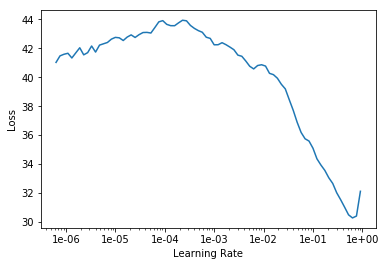

In [84]:
learn.lr_find(); learn.recorder.plot()


In [85]:
lr = 1e-02

In [86]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,31.323477,18.691595,00:00
1,14.006536,8.583277,00:00
2,9.331456,6.905969,00:00
3,7.848967,7.341440,00:00
4,7.182389,7.252595,00:00


In [87]:
learn.save('stage-1')

In [88]:
learn.load('stage-1');

In [89]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


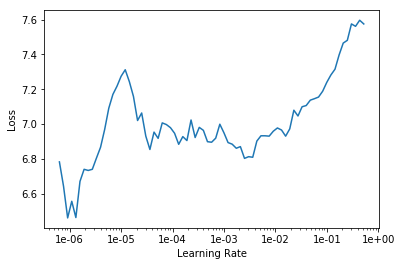

In [90]:
learn.lr_find(); learn.recorder.plot()

In [91]:
learn.fit_one_cycle(10, slice(2e-05))

epoch,train_loss,valid_loss,time
0,6.789241,7.419087,00:00
1,6.851208,7.226628,00:00
2,6.835963,7.109878,00:00
3,6.853765,7.270301,00:00
4,6.856221,7.271641,00:00
5,6.786930,7.156480,00:00
6,6.772154,7.081643,00:00
7,6.673321,7.122847,00:00
8,6.830526,7.132621,00:00
9,6.782647,7.038356,00:00


In [92]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [93]:
subm_df = pd.DataFrame(test_df["seg_id"])

In [94]:
subm_df["time_to_failure"] = preds.numpy()

In [95]:
subm_df.head()

,seg_id,time_to_failure
0,seg_00030f,2.923770
1,seg_0012b5,5.931650
2,seg_00184e,4.903156
3,seg_003339,8.073957
4,seg_0042cc,7.393991


In [96]:
subm_df.to_csv('submission.csv', index=False)